In [10]:
# Import the necessary libraries
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from pathlib import Path
import pickle
import time
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Create output directories
output_dir = "output_full_res"
model_dir = os.path.join(output_dir, 'models')
results_dir = os.path.join(output_dir, 'results')
os.makedirs(model_dir, exist_ok=True)
os.makedirs(results_dir, exist_ok=True)

Using device: cuda


In [11]:
class FullResHyperspectralDataset(Dataset):
    def __init__(self, pickle_file, chunk_size=None, normalize=True):
        """
        Dataset for full-resolution hyperspectral data with mask handling

        Args:
            pickle_file: Path to pickle file
            chunk_size: Optional size to divide image for memory efficiency (None for full image)
            normalize: Whether to normalize the data
        """
        self.pickle_file = Path(pickle_file)
        self.chunk_size = chunk_size
        self.normalize = normalize

        # Load the data
        print(f"Loading data from {self.pickle_file}...")
        with open(self.pickle_file, 'rb') as f:
            self.data_dict = pickle.load(f)

        # Get dimensions
        self.excitation_wavelengths = sorted([float(ex) for ex in self.data_dict['data'].keys()])
        print(f"Found {len(self.excitation_wavelengths)} excitation wavelengths")

        # Get dimensions from first excitation
        first_ex = str(self.excitation_wavelengths[0])
        self.height, self.width, _ = self.data_dict['data'][first_ex]['cube'].shape
        print(f"Image dimensions: {self.height} x {self.width}")

        # Create data and mask tensors
        self._create_data_and_mask()

        # Set up chunks if needed
        if chunk_size is not None:
            self._setup_chunks()

    def _create_data_and_mask(self):
        """Create data tensor and corresponding mask for the entire image"""
        # Find maximum number of emission bands across all excitations
        self.n_excitations = len(self.excitation_wavelengths)
        self.max_emissions = max(len(self.data_dict['data'][str(ex)]['wavelengths'])
                                for ex in self.excitation_wavelengths)
        print(f"Maximum emission bands: {self.max_emissions}")

        # Create tensors
        self.data_tensor = np.zeros((self.n_excitations, self.max_emissions, self.height, self.width))
        self.mask_tensor = np.zeros((self.n_excitations, self.max_emissions, self.height, self.width), dtype=bool)
        self.wavelength_info = []

        # Fill tensors
        for ex_idx, ex in enumerate(self.excitation_wavelengths):
            ex_str = str(ex)
            cube = self.data_dict['data'][ex_str]['cube']
            wavelengths = self.data_dict['data'][ex_str]['wavelengths']
            self.wavelength_info.append(wavelengths)

            # Transpose to [emissions, height, width]
            transposed_cube = np.transpose(cube, (2, 0, 1))

            # Fill data and mask
            n_em = len(wavelengths)
            self.data_tensor[ex_idx, :n_em, :, :] = transposed_cube
            self.mask_tensor[ex_idx, :n_em, :, :] = ~np.isnan(transposed_cube)

        # Replace NaNs with zeros for convenience
        self.data_tensor = np.nan_to_num(self.data_tensor, nan=0.0)

        # Normalize if requested
        if self.normalize:
            # Normalize each excitation-emission combination separately
            for ex_idx in range(self.n_excitations):
                for em_idx in range(self.max_emissions):
                    # Only normalize if we have valid data
                    if np.any(self.mask_tensor[ex_idx, em_idx]):
                        valid_data = self.data_tensor[ex_idx, em_idx][self.mask_tensor[ex_idx, em_idx]]
                        if valid_data.size > 0:
                            # Use 99th percentile to avoid outliers
                            scale_factor = np.percentile(valid_data, 99)
                            if scale_factor > 0:
                                self.data_tensor[ex_idx, em_idx] /= scale_factor

        # Report mask statistics
        valid_percentage = self.mask_tensor.sum() / self.mask_tensor.size * 100
        print(f"Valid data percentage: {valid_percentage:.2f}%")

    def _setup_chunks(self):
        """Setup chunks for memory-efficient processing with fixed size"""
        # Calculate number of chunks
        chunks_y = int(np.ceil(self.height / self.chunk_size))
        chunks_x = int(np.ceil(self.width / self.chunk_size))

        # To ensure all chunks have the same dimensions, we'll pad the image
        # Calculate padded dimensions
        padded_height = chunks_y * self.chunk_size
        padded_width = chunks_x * self.chunk_size

        # Pad the tensor if needed
        if padded_height > self.height or padded_width > self.width:
            pad_h = padded_height - self.height
            pad_w = padded_width - self.width

            # Create padded tensors
            padded_data = np.zeros((self.n_excitations, self.max_emissions, padded_height, padded_width))
            padded_mask = np.zeros((self.n_excitations, self.max_emissions, padded_height, padded_width), dtype=bool)

            # Copy original data
            padded_data[:, :, :self.height, :self.width] = self.data_tensor
            padded_mask[:, :, :self.height, :self.width] = self.mask_tensor

            # Update tensors
            self.data_tensor = padded_data
            self.mask_tensor = padded_mask

            # Update dimensions
            self.padded_height = padded_height
            self.padded_width = padded_width
            self.original_height = self.height
            self.original_width = self.width
            self.height = padded_height
            self.width = padded_width
        else:
            self.padded_height = self.height
            self.padded_width = self.width
            self.original_height = self.height
            self.original_width = self.width

        # Generate chunk positions
        self.chunk_positions = []
        for i in range(chunks_y):
            y_start = i * self.chunk_size
            y_end = y_start + self.chunk_size  # This ensures all chunks have the same size
            for j in range(chunks_x):
                x_start = j * self.chunk_size
                x_end = x_start + self.chunk_size  # This ensures all chunks have the same size
                self.chunk_positions.append((y_start, y_end, x_start, x_end))

        print(f"Created {len(self.chunk_positions)} chunks of size {self.chunk_size}x{self.chunk_size}")

    def __len__(self):
        """Return dataset length"""
        if self.chunk_size is not None:
            return len(self.chunk_positions)
        else:
            return 1

    def __getitem__(self, idx):
        """Get data with mask"""
        if self.chunk_size is not None:
            # Extract chunk
            y_start, y_end, x_start, x_end = self.chunk_positions[idx]
            data = self.data_tensor[:, :, y_start:y_end, x_start:x_end].copy()
            mask = self.mask_tensor[:, :, y_start:y_end, x_start:x_end].copy()
            positions = (y_start, y_end, x_start, x_end)
        else:
            # Return full tensor
            data = self.data_tensor.copy()
            mask = self.mask_tensor.copy()
            positions = (0, self.height, 0, self.width)

        # Convert to tensors
        data_tensor = torch.tensor(data, dtype=torch.float32)
        mask_tensor = torch.tensor(mask, dtype=torch.float32)  # Convert bool to float for math operations
        pos_tensor = torch.tensor(positions, dtype=torch.long)

        return {
            'data': data_tensor,
            'mask': mask_tensor,
            'positions': pos_tensor
        }

In [12]:
class ConvBlock(nn.Module):
    """Basic convolutional block with batch normalization"""
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))

class FullResHyperspectralAutoencoder(nn.Module):
    """
    Autoencoder for full resolution hyperspectral data with mask handling
    Uses fully convolutional architecture to handle arbitrary input sizes
    """
    def __init__(self, n_excitations, n_emissions, latent_channels=64, n_clusters=5):
        super().__init__()

        self.n_excitations = n_excitations
        self.n_emissions = n_emissions
        self.latent_channels = latent_channels
        self.n_clusters = n_clusters

        # Number of channels when flattening excitation-emission dims
        self.n_channels = n_excitations * n_emissions

        # Encoder pathway - fully convolutional
        self.encoder = nn.Sequential(
            # First layer
            ConvBlock(self.n_channels, 32),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Second layer
            ConvBlock(32, 64),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Third layer
            ConvBlock(64, latent_channels),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Final encoder layer - this becomes our latent representation
            ConvBlock(latent_channels, latent_channels)
        )

        # Decoder pathway
        self.decoder = nn.Sequential(
            # First decoder layer
            ConvBlock(latent_channels, latent_channels),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            ConvBlock(latent_channels, 64),

            # Second decoder layer
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            ConvBlock(64, 32),

            # Final decoder layer
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            ConvBlock(32, self.n_channels),

            # Output activation
            nn.Sigmoid()  # Normalize output to [0,1]
        )

        # Clustering head - applies 1x1 convolutions to produce cluster probabilities
        # at each spatial location without changing dimensions
        self.cluster_head = nn.Sequential(
            nn.Conv2d(latent_channels, latent_channels, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(latent_channels, n_clusters, kernel_size=1)
        )

    def forward(self, x, mask=None):
        """
        Forward pass through the autoencoder

        Args:
            x: Input tensor [batch, n_excitations, n_emissions, height, width]
            mask: Mask tensor [batch, n_excitations, n_emissions, height, width]

        Returns:
            reconstructed: Reconstructed data
            latent: Latent features (for clustering)
            cluster_logits: Clustering logits at each spatial position
        """
        batch_size = x.shape[0]

        # Store original shape
        original_shape = x.shape

        # Reshape to merge excitation and emission dimensions
        x_reshaped = x.reshape(batch_size, self.n_channels, original_shape[3], original_shape[4])

        # Encode
        latent = self.encoder(x_reshaped)

        # Get cluster logits from latent features (these will be at reduced resolution)
        cluster_logits = self.cluster_head(latent)

        # Decode
        reconstructed_flat = self.decoder(latent)

        # Reshape back to original dimensions
        reconstructed = reconstructed_flat.reshape(
            batch_size,
            original_shape[1],  # n_excitations
            original_shape[2],  # n_emissions
            original_shape[3],  # height
            original_shape[4]   # width
        )

        # Apply mask
        if mask is not None:
            reconstructed = reconstructed * mask

        return reconstructed, latent, cluster_logits

In [13]:
class MaskedMSELoss(nn.Module):
    """MSE loss that only considers masked (valid) values"""
    def __init__(self):
        super().__init__()

    def forward(self, pred, target, mask):
        """
        Compute MSE only on valid values
        """
        # Element-wise squared error
        squared_diff = (pred - target) ** 2

        # Apply mask
        masked_squared_diff = squared_diff * mask

        # Sum and normalize by number of valid elements
        valid_elements = mask.sum() + 1e-8  # Avoid division by zero
        loss = masked_squared_diff.sum() / valid_elements

        return loss

class FullResClusteringLoss(nn.Module):
    """
    Combined loss function for full-resolution clustering with reconstruction
    """
    def __init__(self, n_clusters, alpha=1.0, beta=0.1, gamma=0.01):
        super().__init__()
        self.n_clusters = n_clusters

        # Loss weights
        self.alpha = alpha  # Reconstruction weight
        self.beta = beta    # Clustering weight
        self.gamma = gamma  # Regularization weight

        # MSE loss for reconstruction
        self.mse_loss = MaskedMSELoss()

        # Cluster centroids (will be updated during training)
        self.centroids = None
        self.initialized = False

    def forward(self, original, reconstructed, latent_features, mask, target_distribution=None):
        """
        Compute combined loss
        """
        # Reconstruction loss
        recon_loss = self.mse_loss(reconstructed, original, mask)

        # For clustering, we need to handle the spatial dimensions
        batch_size, channels, height, width = latent_features.shape

        # Reshape latent features to [batch*height*width, channels]
        features_flat = latent_features.permute(0, 2, 3, 1).reshape(-1, channels)

        # Initialize centroids if not done yet
        if not self.initialized or self.centroids is None:
            # Sample features for k-means (to avoid memory issues)
            max_samples = min(100000, features_flat.shape[0])
            sample_indices = torch.randperm(features_flat.shape[0])[:max_samples]
            sample_features = features_flat[sample_indices].detach().cpu().numpy()

            # Check for NaN values
            if np.isnan(sample_features).any():
                print(f"Warning: Found NaN values in features")
                sample_features = np.nan_to_num(sample_features, nan=0.0)

            # Initialize k-means
            try:
                kmeans = KMeans(n_clusters=self.n_clusters, random_state=42)
                kmeans.fit(sample_features)
                self.centroids = torch.tensor(
                    kmeans.cluster_centers_,
                    dtype=torch.float,
                    device=features_flat.device
                )
                self.initialized = True
            except Exception as e:
                print(f"Error initializing KMeans: {e}")
                # Fallback to random centroids
                self.centroids = torch.randn(
                    self.n_clusters, channels,
                    device=features_flat.device
                )
                self.initialized = True

        # Compute distances to centroids
        distances = torch.cdist(features_flat, self.centroids)

        # Convert distances to probabilities (soft assignments)
        q = 1.0 / (1.0 + distances**2)
        q = q / q.sum(dim=1, keepdim=True)

        # Calculate clustering loss
        if target_distribution is not None:
            # KL divergence with target distribution
            cluster_loss = F.kl_div(q.log(), target_distribution, reduction='batchmean')
        else:
            # Basic clustering loss (minimize distance to nearest centroid)
            min_distances = torch.min(distances, dim=1)[0]
            cluster_loss = torch.mean(min_distances)

        # Regularization: feature variance to avoid trivial solutions
        feature_var = torch.var(features_flat, dim=0).mean()
        reg_loss = 1.0 / (feature_var + 1e-6)

        # Combined loss
        total_loss = (
            self.alpha * recon_loss +
            self.beta * cluster_loss +
            self.gamma * reg_loss
        )

        return total_loss, recon_loss, cluster_loss, reg_loss

    def update_centroids(self, latent_features):
        """Update centroids using current batch"""
        batch_size, channels, height, width = latent_features.shape
        features_flat = latent_features.permute(0, 2, 3, 1).reshape(-1, channels)

        # Sample features for k-means (to avoid memory issues)
        max_samples = min(100000, features_flat.shape[0])
        sample_indices = torch.randperm(features_flat.shape[0])[:max_samples]
        sample_features = features_flat[sample_indices].detach().cpu().numpy()

        # Handle NaN values
        sample_features = np.nan_to_num(sample_features, nan=0.0)

        # Update centroids
        try:
            kmeans = KMeans(n_clusters=self.n_clusters, random_state=42)
            kmeans.fit(sample_features)
            self.centroids = torch.tensor(
                kmeans.cluster_centers_,
                dtype=torch.float,
                device=features_flat.device
            )
        except Exception as e:
            print(f"Error updating centroids: {e}")

        return self.centroids

In [14]:
def train_full_res_autoencoder(model, train_loader, val_loader=None,
                          n_epochs=30, n_clusters=10,
                          learning_rate=0.0001, device='cuda',
                          model_save_path='models',
                          update_interval=5):
    """
    Train the full-resolution autoencoder
    """
    # Set device
    model = model.to(device)

    # Initialize criterion and optimizer
    criterion = FullResClusteringLoss(n_clusters=n_clusters, alpha=1.0, beta=0.1, gamma=0.01)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5, verbose=True
    )

    # Early stopping
    early_stopping = {
        'best_loss': float('inf'),
        'counter': 0,
        'patience': 15,
        'stop': False
    }

    # History
    history = {
        'train_loss': [],
        'val_loss': [],
        'recon_loss': [],
        'cluster_loss': [],
        'reg_loss': []
    }

    # Start training
    start_time = time.time()
    print(f"Starting training for {n_epochs} epochs...")

    for epoch in range(n_epochs):
        model.train()
        total_loss = 0.0
        recon_loss_sum = 0.0
        cluster_loss_sum = 0.0
        reg_loss_sum = 0.0
        batch_count = 0

        # Training
        for batch_idx, batch in enumerate(train_loader):
            # Move data to device
            data = batch['data'].to(device)
            mask = batch['mask'].to(device)

            # Forward pass
            reconstructed, latent, cluster_logits = model(data, mask)

            # Compute loss
            loss, recon_loss, cluster_loss, reg_loss = criterion(
                data, reconstructed, latent, mask
            )

            # Backward pass
            optimizer.zero_grad()
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            # Update stats
            batch_count += 1
            total_loss += loss.item()
            recon_loss_sum += recon_loss.item()
            cluster_loss_sum += cluster_loss.item()
            reg_loss_sum += reg_loss.item()

            # Print progress
            if (batch_idx + 1) % 5 == 0:
                print(f"Epoch {epoch+1}/{n_epochs}, Batch {batch_idx+1}, "
                      f"Loss: {loss.item():.6f}, Recon: {recon_loss.item():.6f}, "
                      f"Cluster: {cluster_loss.item():.6f}, Reg: {reg_loss.item():.6f}")

        # Update centroids
        if epoch % update_interval == 0 and epoch > 0:
            print("Updating cluster centroids...")
            all_features = []
            model.eval()
            with torch.no_grad():
                for batch in train_loader:
                    data = batch['data'].to(device)
                    mask = batch['mask'].to(device)
                    _, latent, _ = model(data, mask)
                    all_features.append(latent)

            if all_features:
                # Concatenate all features
                all_features = torch.cat(all_features, dim=0)
                criterion.update_centroids(all_features)

        # Compute epoch averages
        avg_loss = total_loss / batch_count
        avg_recon_loss = recon_loss_sum / batch_count
        avg_cluster_loss = cluster_loss_sum / batch_count
        avg_reg_loss = reg_loss_sum / batch_count

        # Validation
        val_loss = 0.0
        if val_loader is not None:
            model.eval()
            val_batch_count = 0
            with torch.no_grad():
                for batch in val_loader:
                    data = batch['data'].to(device)
                    mask = batch['mask'].to(device)

                    # Forward pass
                    reconstructed, latent, _ = model(data, mask)

                    # Compute loss (reconstruction only for simplicity)
                    mse_criterion = MaskedMSELoss()
                    loss = mse_criterion(reconstructed, data, mask)

                    val_loss += loss.item()
                    val_batch_count += 1

            if val_batch_count > 0:
                val_loss /= val_batch_count

                # Update learning rate
                scheduler.step(val_loss)

                # Early stopping check
                if val_loss < early_stopping['best_loss']:
                    early_stopping['best_loss'] = val_loss
                    early_stopping['counter'] = 0

                    # Save best model
                    torch.save(model.state_dict(),
                              os.path.join(model_save_path, 'best_model.pt'))
                    print(f"Saved best model with validation loss: {val_loss:.6f}")
                else:
                    early_stopping['counter'] += 1
                    print(f"Early stopping counter: {early_stopping['counter']}/{early_stopping['patience']}")

                    if early_stopping['counter'] >= early_stopping['patience']:
                        print("Early stopping triggered!")
                        early_stopping['stop'] = True

        # Store history
        history['train_loss'].append(avg_loss)
        history['val_loss'].append(val_loss if val_loader is not None else None)
        history['recon_loss'].append(avg_recon_loss)
        history['cluster_loss'].append(avg_cluster_loss)
        history['reg_loss'].append(avg_reg_loss)

        # Print epoch summary
        elapsed = time.time() - start_time
        print(f"Epoch {epoch+1}/{n_epochs}, Time: {elapsed:.2f}s, "
              f"Loss: {avg_loss:.6f}, Recon: {avg_recon_loss:.6f}, "
              f"Cluster: {avg_cluster_loss:.6f}, Reg: {avg_reg_loss:.6f}" +
              (f", Val Loss: {val_loss:.6f}" if val_loader is not None else ""))

        # Save checkpoint
        if (epoch + 1) % 10 == 0:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'history': history
            }, os.path.join(model_save_path, f'checkpoint_{epoch+1}.pt'))

        # Check early stopping
        if early_stopping['stop']:
            break

    # Save final model
    torch.save(model.state_dict(),
              os.path.join(model_save_path, 'final_model.pt'))

    # Save history
    np.save(os.path.join(model_save_path, 'training_history.npy'), history)

    # Load best model if validation was used
    if val_loader is not None:
        model.load_state_dict(torch.load(os.path.join(model_save_path, 'best_model.pt')))

    return model, history

In [15]:
# Set the data path to your pickle file
data_path = "../Data/Kiwi Experiment/pickles/masked_KiwiData.pkl"

# For memory efficiency, we'll process the image in larger chunks
chunk_size = 256  # Can adjust based on your available memory

# Create dataset
dataset = FullResHyperspectralDataset(
    pickle_file=data_path,
    chunk_size=chunk_size,
    normalize=True
)

# Check sample data
sample = dataset[0]
print(f"Sample data shape: {sample['data'].shape}")
print(f"Sample mask shape: {sample['mask'].shape}")
print(f"Valid data percentage in sample: {sample['mask'].sum().item() / sample['mask'].numel() * 100:.2f}%")

# Split into train/validation
from torch.utils.data import random_split
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print(f"Training chunks: {len(train_dataset)}")
print(f"Validation chunks: {len(val_dataset)}")

# Create data loaders
batch_size = 4  # Adjust based on your GPU memory
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0
)

Loading data from ..\Data\Kiwi Experiment\pickles\masked_KiwiData.pkl...
Found 21 excitation wavelengths
Image dimensions: 1024 x 1392
Maximum emission bands: 31
Valid data percentage: 71.45%
Created 24 chunks of size 256x256
Sample data shape: torch.Size([21, 31, 256, 256])
Sample mask shape: torch.Size([21, 31, 256, 256])
Valid data percentage in sample: 32.03%
Training chunks: 19
Validation chunks: 5


In [19]:
# Create model
n_excitations = dataset.n_excitations
n_emissions = dataset.max_emissions
n_clusters = 10  # Number of clusters

model = FullResHyperspectralAutoencoder(
    n_excitations=n_excitations,
    n_emissions=n_emissions,
    latent_channels=64,  # Number of channels in latent space
    n_clusters=n_clusters
)
model = model.to(device)
# Print model summary
print(f"Created autoencoder with:")
print(f"  {n_excitations} excitation wavelengths")
print(f"  {n_emissions} emission bands")
print(f"  {n_clusters} clusters")
print(f"  {sum(p.numel() for p in model.parameters()):,} total parameters")

# Test forward pass
with torch.no_grad():
    sample = next(iter(train_loader))
    data = sample['data'].to(device)
    mask = sample['mask'].to(device)

    reconstructed, latent, cluster_logits = model(data, mask)
    print(f"Forward pass successful!")
    print(f"Input shape: {data.shape}")
    print(f"Mask shape: {mask.shape}")
    print(f"Reconstruction shape: {reconstructed.shape}")
    print(f"Latent shape: {latent.shape}")
    print(f"Cluster logits shape: {cluster_logits.shape}")

Created autoencoder with:
  21 excitation wavelengths
  31 emission bands
  10 clusters
  567,211 total parameters
Forward pass successful!
Input shape: torch.Size([4, 21, 31, 256, 256])
Mask shape: torch.Size([4, 21, 31, 256, 256])
Reconstruction shape: torch.Size([4, 21, 31, 256, 256])
Latent shape: torch.Size([4, 64, 32, 32])
Cluster logits shape: torch.Size([4, 10, 32, 32])


C:\Users\meloy\PycharmProjects\Capstone\.venv\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Starting training for 30 epochs...
Epoch 1/30, Batch 5, Loss: 0.519955, Recon: 0.159274, Cluster: 3.337693, Reg: 2.691117
Saved best model with validation loss: 0.148438
Epoch 1/30, Time: 19.12s, Loss: 0.523374, Recon: 0.151223, Cluster: 3.458024, Reg: 2.634823, Val Loss: 0.148438
Epoch 2/30, Batch 5, Loss: 0.479342, Recon: 0.154968, Cluster: 2.951437, Reg: 2.923007
Early stopping counter: 1/15
Epoch 2/30, Time: 36.11s, Loss: 0.460028, Recon: 0.140449, Cluster: 2.929360, Reg: 2.664269, Val Loss: 0.152453
Epoch 3/30, Batch 5, Loss: 0.484320, Recon: 0.172548, Cluster: 2.835013, Reg: 2.827079
Early stopping counter: 2/15
Epoch 3/30, Time: 53.17s, Loss: 0.449561, Recon: 0.134878, Cluster: 2.884354, Reg: 2.624773, Val Loss: 0.155103
Epoch 4/30, Batch 5, Loss: 0.435346, Recon: 0.126460, Cluster: 2.810282, Reg: 2.785782
Early stopping counter: 3/15
Epoch 4/30, Time: 70.07s, Loss: 0.430437, Recon: 0.133249, Cluster: 2.705013, Reg: 2.668702, Val Loss: 0.160333
Epoch 5/30, Batch 5, Loss: 0.43333

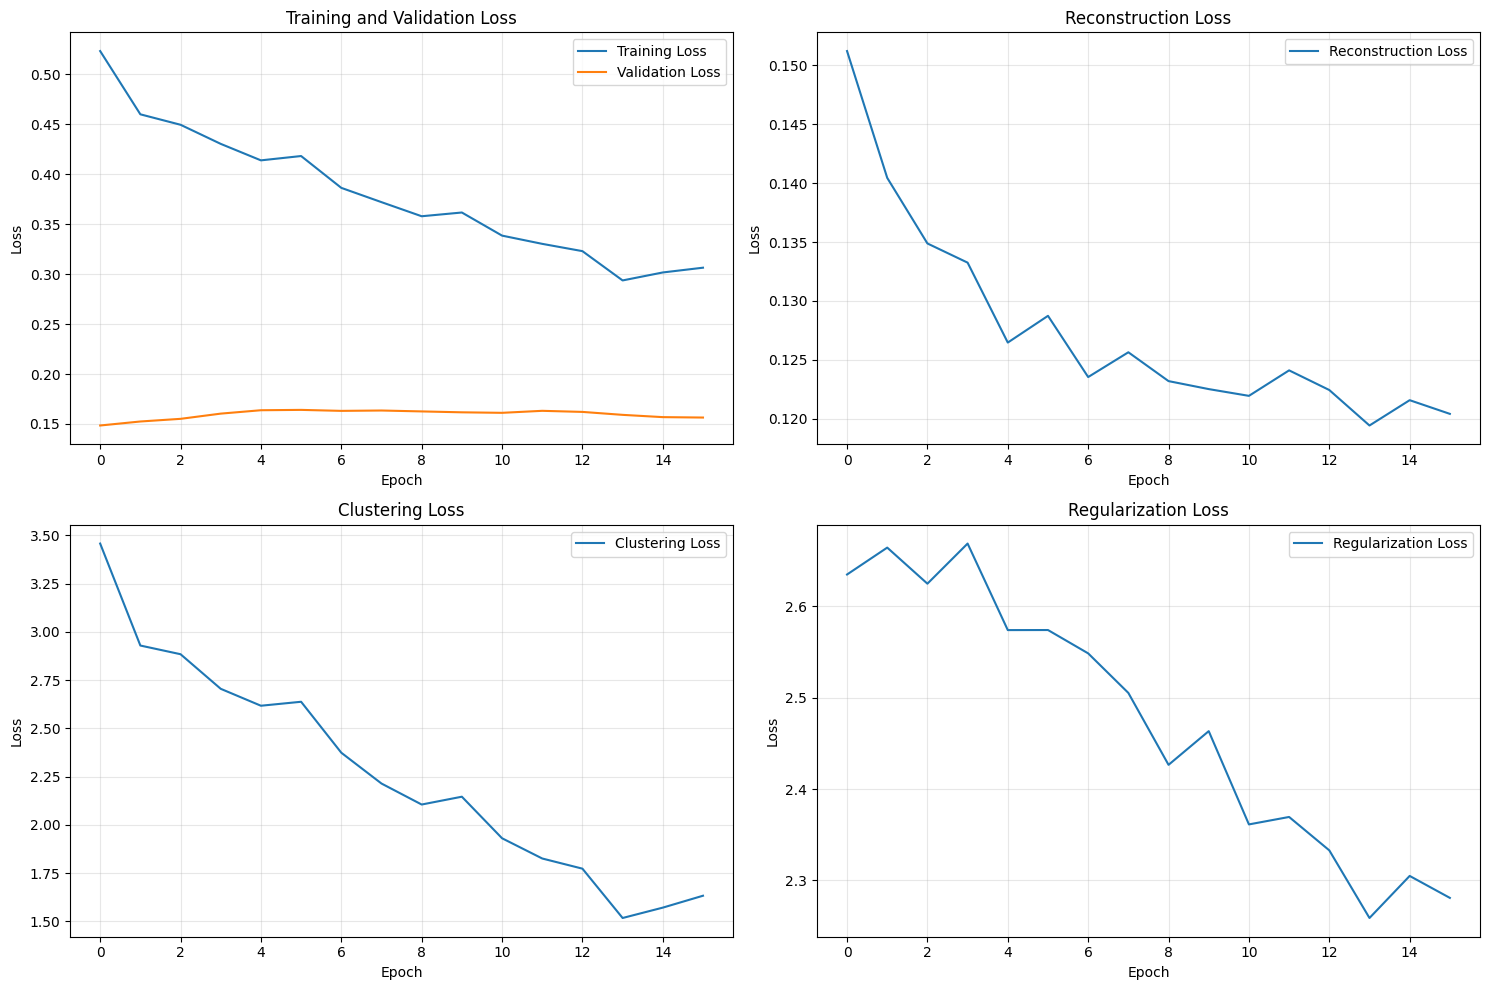

In [20]:
# Training parameters
epochs = 30
learning_rate = 0.0001
update_interval = 5

# Train the model
model, history = train_full_res_autoencoder(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    n_epochs=epochs,
    n_clusters=n_clusters,
    learning_rate=learning_rate,
    device=device,
    model_save_path=model_dir,
    update_interval=update_interval
)

# Plot training history
plt.figure(figsize=(15, 10))

# Plot loss curves
plt.subplot(2, 2, 1)
plt.plot(history['train_loss'], label='Training Loss')
if history['val_loss'][0] is not None:
    plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot reconstruction loss
plt.subplot(2, 2, 2)
plt.plot(history['recon_loss'], label='Reconstruction Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Reconstruction Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot clustering loss
plt.subplot(2, 2, 3)
plt.plot(history['cluster_loss'], label='Clustering Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Clustering Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot regularization loss
plt.subplot(2, 2, 4)
plt.plot(history['reg_loss'], label='Regularization Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Regularization Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'training_history.png'), dpi=300)
plt.show()

Loading data from ..\Data\Kiwi Experiment\pickles\masked_KiwiData.pkl...
Found 21 excitation wavelengths
Image dimensions: 1024 x 1392
Maximum emission bands: 31
Valid data percentage: 71.45%
Created 24 chunks of size 256x256
Processed chunk 10/24
Processed chunk 20/24
Processed chunk 24/24


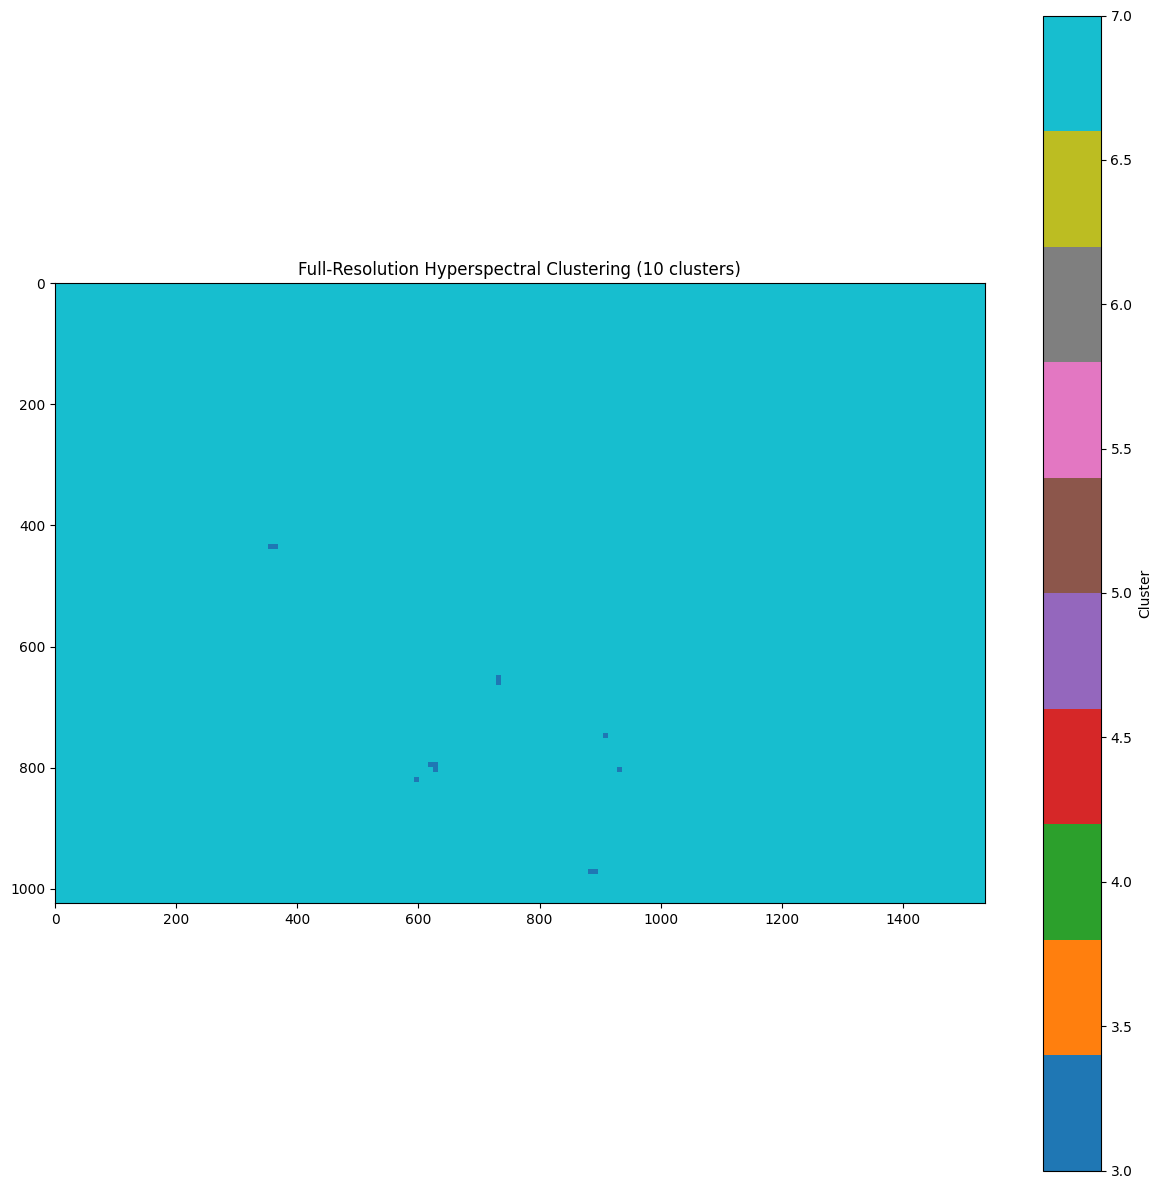

In [21]:
# Create a dataset for full-image prediction
# We'll use chunks for memory efficiency
predict_dataset = FullResHyperspectralDataset(
    pickle_file=data_path,
    chunk_size=chunk_size
)

# Create a tensor to store results at full resolution
height, width = predict_dataset.height, predict_dataset.width
cluster_map = np.zeros((height, width), dtype=int)
confidence_map = np.zeros((height, width), dtype=float)

# Process each chunk
model.eval()
with torch.no_grad():
    for idx in range(len(predict_dataset)):
        batch = predict_dataset[idx]
        data = batch['data'].unsqueeze(0).to(device)  # Add batch dimension
        mask = batch['mask'].unsqueeze(0).to(device)
        positions = batch['positions'].numpy()
        y_start, y_end, x_start, x_end = positions

        # Forward pass
        _, latent, cluster_logits = model(data, mask)

        # Get cluster predictions (softmax over cluster dimension)
        probs = F.softmax(cluster_logits, dim=1)
        # Get max probability and corresponding cluster index
        confidence, predictions = torch.max(probs, dim=1)

        # Upsample predictions to original resolution if needed
        # (cluster_logits might be at reduced resolution due to downsampling)
        if predictions.shape[1:] != data.shape[3:5]:
            predictions = F.interpolate(
                predictions.float().unsqueeze(1),
                size=(y_end-y_start, x_end-x_start),
                mode='nearest'
            ).squeeze(1).long()

            confidence = F.interpolate(
                confidence.unsqueeze(1),
                size=(y_end-y_start, x_end-x_start),
                mode='bilinear',
                align_corners=False
            ).squeeze(1)

        # Convert to numpy for storing
        pred_np = predictions[0].cpu().numpy()
        conf_np = confidence[0].cpu().numpy()

        # Store in the full-resolution maps
        cluster_map[y_start:y_end, x_start:x_end] = pred_np
        confidence_map[y_start:y_end, x_start:x_end] = conf_np

        # Print progress
        if (idx + 1) % 10 == 0 or idx == len(predict_dataset) - 1:
            print(f"Processed chunk {idx+1}/{len(predict_dataset)}")

# Create a validity mask (where we have data)
validity_mask = confidence_map > 0

# Visualize the full-resolution cluster map
plt.figure(figsize=(15, 15))
plt.imshow(cluster_map, cmap='tab10', interpolation='nearest')
plt.colorbar(label='Cluster')
plt.title(f'Full-Resolution Hyperspectral Clustering ({n_clusters} clusters)')
plt.savefig(os.path.join(results_dir, 'full_res_cluster_map.png'), dpi=300, bbox_inches='tight')
plt.show()

# Save the cluster map
np.save(os.path.join(results_dir, 'cluster_map.npy'), cluster_map)
np.save(os.path.join(results_dir, 'confidence_map.npy'), confidence_map)

In [ ]:
# Analyze spectral characteristics of each cluster
cluster_stats = {}

# Get excitation and emission wavelengths
ex_wavelengths = dataset.excitation_wavelengths
em_wavelengths = dataset.wavelength_info

# For each cluster, analyze spectral signature
for cluster_idx in range(n_clusters):
    # Get mask for this cluster
    cluster_mask = cluster_map == cluster_idx

    # Skip if cluster is empty
    if not np.any(cluster_mask):
        continue

    # Get pixel count and percentage
    pixel_count = np.sum(cluster_mask)
    percentage = pixel_count / np.sum(validity_mask) * 100

    # Store basic stats
    cluster_stats[cluster_idx] = {
        'pixel_count': pixel_count,
        'percentage': percentage,
        'spectra': {}
    }

    # Get mean spectrum for each excitation
    for ex_idx, ex in enumerate(ex_wavelengths):
        # Get wavelengths for this excitation
        wavelengths = em_wavelengths[ex_idx]

        # Get data for this excitation
        ex_data = dataset.data_tensor[ex_idx, :len(wavelengths)]

        # Extract data for cluster pixels (memory-efficient approach)
        # Extract indices of pixels in this cluster
        y_indices, x_indices = np.where(cluster_mask)

        # Sample up to 10,000 pixels for memory efficiency
        if len(y_indices) > 10000:
            sample_indices = np.random.choice(len(y_indices), 10000, replace=False)
            y_indices = y_indices[sample_indices]
            x_indices = x_indices[sample_indices]

        # Get spectra for these pixels
        spectra = []
        for i in range(len(y_indices)):
            y, x = y_indices[i], x_indices[i]
            spectra.append(ex_data[:, y, x])

        if spectra:
            # Calculate mean spectrum
            mean_spectrum = np.mean(spectra, axis=0)

            # Find peak wavelength and value
            peak_idx = np.argmax(mean_spectrum)
            if peak_idx < len(wavelengths):
                peak_wavelength = wavelengths[peak_idx]
                peak_value = mean_spectrum[peak_idx]
            else:
                peak_wavelength = None
                peak_value = None

            # Store spectral data
            cluster_stats[cluster_idx]['spectra'][ex] = {
                'wavelengths': wavelengths,
                'mean_spectrum': mean_spectrum,
                'peak_wavelength': peak_wavelength,
                'peak_value': peak_value
            }

# Print summary
print("\nCluster Statistics:\n")
print(f"{'Cluster':<10} {'Pixels':<10} {'Percentage':<15} {'Notable Peaks'}")
print("-" * 70)

for cluster_idx, stats in cluster_stats.items():
    # Get top peaks
    peak_info = []
    for ex, ex_data in stats['spectra'].items():
        if ex_data['peak_wavelength'] is not None:
            peak_info.append((ex, ex_data['peak_wavelength'], ex_data['peak_value']))

    # Sort by intensity
    peak_info.sort(key=lambda x: x[2] if x[2] is not None else 0, reverse=True)

    # Format peak info text
    peak_text = ", ".join(f"Ex:{ex:.0f}/Em:{em:.0f}" for ex, em, _ in peak_info[:2])

    print(f"{cluster_idx:<10} {stats['pixel_count']:<10} {stats['percentage']:.2f}%{' ':<10} {peak_text}")

# Plot spectral signatures by cluster
plt.figure(figsize=(15, 12))

# Sample a few excitation wavelengths to plot
plot_ex_indices = np.linspace(0, len(ex_wavelengths)-1, min(5, len(ex_wavelengths)), dtype=int)

for i, ex_idx in enumerate(plot_ex_indices):
    ex = ex_wavelengths[ex_idx]

    plt.subplot(len(plot_ex_indices), 1, i+1)

    for cluster_idx, stats in cluster_stats.items():
        if ex in stats['spectra']:
            wavelengths = stats['spectra'][ex]['wavelengths']
            spectrum = stats['spectra'][ex]['mean_spectrum']
            plt.plot(wavelengths, spectrum, '-', linewidth=2, label=f'Cluster {cluster_idx}')

    plt.xlabel('Emission Wavelength (nm)')
    plt.ylabel('Mean Intensity')
    plt.title(f'Excitation: {ex} nm')
    plt.grid(True, alpha=0.3)

    if i == 0:  # Only add legend to first plot
        plt.legend(loc='best')

plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'spectral_signatures.png'), dpi=300, bbox_inches='tight')
plt.show()

# Save cluster stats
with open(os.path.join(results_dir, 'cluster_stats.pkl'), 'wb') as f:
    pickle.dump(cluster_stats, f)